In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

In [28]:
data = yf.download('AAPL', start='2015-01-01', end='2025-05-08')
data.reset_index(inplace=True)
data = data[['Date', 'Close']]
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [29]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})
data.set_index('ds', inplace=True)

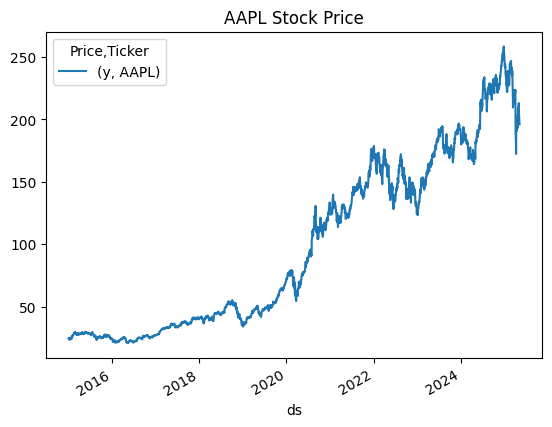

In [30]:
data.plot(title='AAPL Stock Price')
plt.show()

In [31]:
model_arima = ARIMA(data['y'], order=(5,1,0))
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=30)

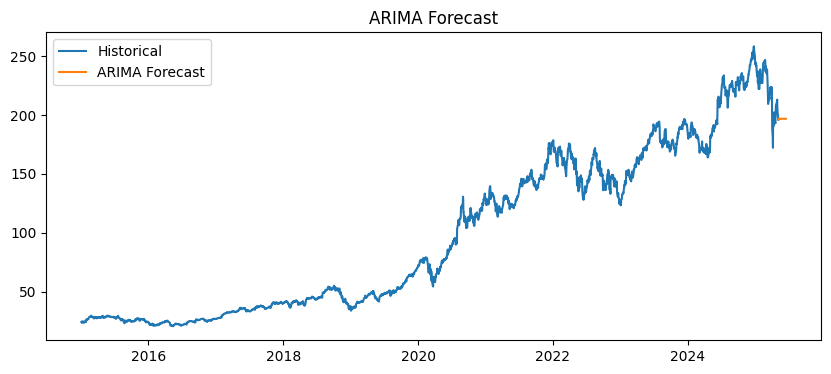

In [32]:
plt.figure(figsize=(10,4))
plt.plot(data['y'], label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), forecast_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [33]:
model_sarima = SARIMAX(data['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
result_sarima = model_sarima.fit()
forecast_sarima = result_sarima.forecast(steps=30)

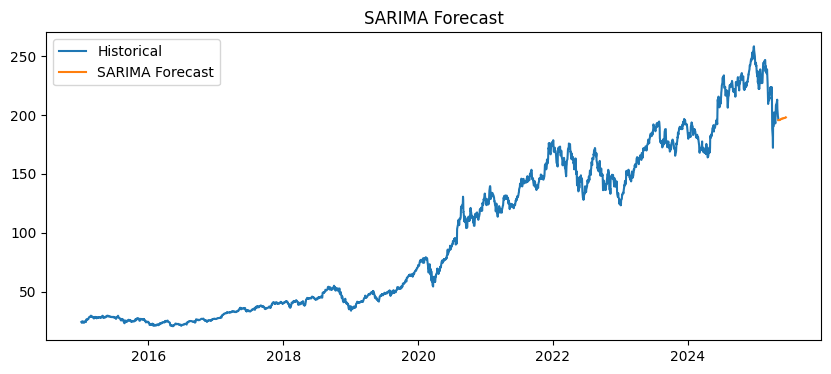

In [34]:
plt.figure(figsize=(10,4))
plt.plot(data['y'], label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), forecast_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [35]:
print(data.columns)
print(data.head())

MultiIndex([('y', 'AAPL')],
           names=['Price', 'Ticker'])
Price               y
Ticker           AAPL
ds                   
2015-01-02  24.288578
2015-01-05  23.604332
2015-01-06  23.606552
2015-01-07  23.937571
2015-01-08  24.857304


In [36]:
data.columns = data.columns.get_level_values(0) 
df_prophet = data.reset_index()
df_prophet = df_prophet.rename(columns={'ds': 'ds', 'y': 'y'})  
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
df_prophet.dropna(inplace=True)

In [37]:
from prophet import Prophet
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing


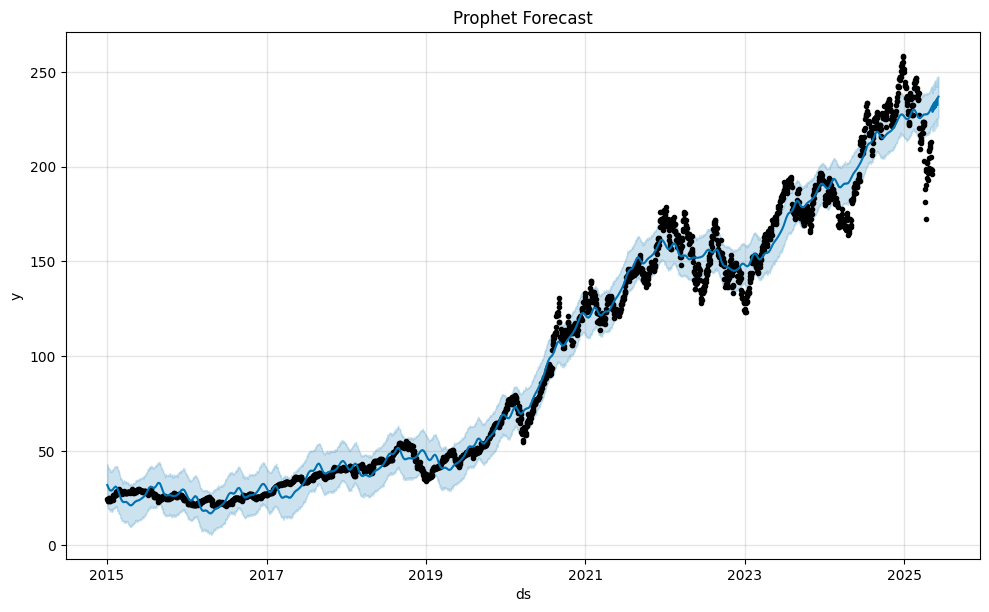

In [38]:
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

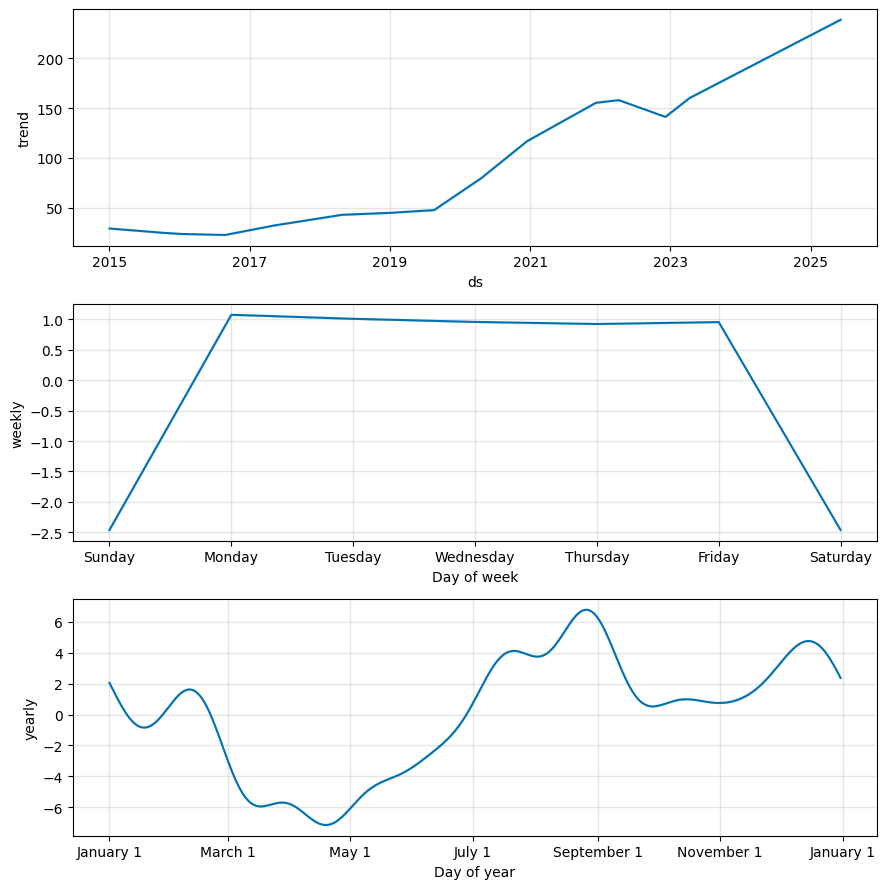

In [39]:
model.plot_components(forecast)
plt.show()

In [40]:
df_lstm = data[['y']].copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm)
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(x), np.array(y)
seq_len = 60
x, y_lstm = create_sequences(scaled, seq_len)

In [41]:
split = int(0.8 * len(x))
x_train, y_train = x[:split], y_lstm[:split]
x_test, y_test = x[split:], y_lstm[split:]

In [42]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0203
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.8919e-04
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9926e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8990e-04
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0066e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8807e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6461e-04
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4894e-04
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1200e-04
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2642e-04


In [43]:
pred = model_lstm.predict(x_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


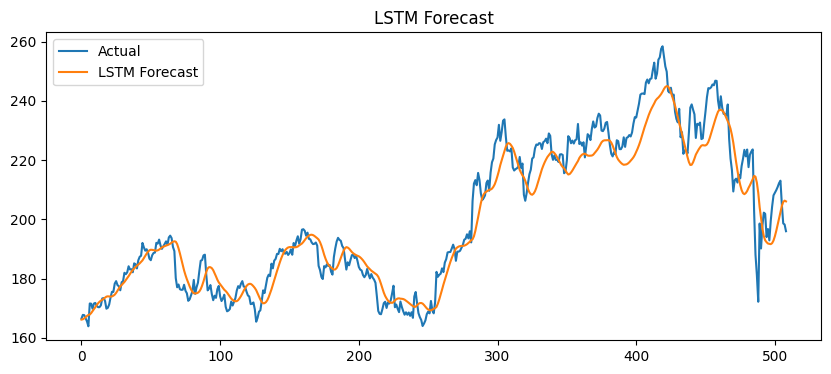

In [44]:
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='LSTM Forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()